<a href="https://colab.research.google.com/github/KojoBarbie/CNN_practice_1/blob/main/CNN_practice_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNを用いて画像分類
pokeapiを使用して集めたポケモンの写真をもとに、そのポケモンが伝説のポケモンであるかどうかを判定する画像分類を作る。
このノートブックでは、画像の収集を行う。

## import
必要なモジュールなどのインポート

In [ ]:
# Googleドライブをマウント(Colabの場合)
from google.colab import drive
drive.mount('/content/drive')

# 定番
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 画像収集の時に使う
import pprint
import urllib.error
import urllib.request

# 水増しの時に使う
import cv2
import glob

# CNNの時に使う
import torch
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data as data_utils#データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from PIL import Image

Mounted at /content/drive


## 画像を収集する
pokeapiから画像のリンクを開き、ダウンロードする

In [ ]:
# 画像をURLからダウンロードする関数
# 参考: https://note.nkmk.me/python-download-web-images/
def download_file(url, file_name):
    try:
        with urllib.request.urlopen(url) as web_file, open(file_name, 'wb') as local_file:
            local_file.write(web_file.read())
    except urllib.error.URLError as e:
        print(e)

In [ ]:
# pokeapiを利用して画像を収集する
def collect_png(rootpath, rooturl):
  for i in range(1, 899):
    url = rooturl + str(i)+ ".png"
    path = rootpath + str(i).zfill(3) + ".png" 
    download_file(url, path)
    if i % 100 == 0:
      print(str(i) + "まで終わった")

In [ ]:
# ひとまずartworkだけダウンロードしてみる
rootpath = "/content/drive/MyDrive/10_study/CNN/data/artwork/"
rooturl = "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/official-artwork/"

collect_png(rootpath, rooturl)

100まで終わった
200まで終わった
300まで終わった
400まで終わった
500まで終わった
600まで終わった
700まで終わった
800まで終わった


In [ ]:
# homeもダウンロード
rootpath = "/content/drive/MyDrive/10_study/CNN/data/home/"
rooturl = "https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/other/home/"

collect_png(rootpath, rooturl)

100まで終わった
200まで終わった
300まで終わった
400まで終わった
500まで終わった
600まで終わった
700まで終わった
HTTP Error 404: Not Found
800まで終わった


## 画像の水増し
約1800枚の画像を入手できたが、伝説のポケモン（UBなども入れて79匹）のデータが少し足りないので、水増しする。  
色調転換・左右反転・左右90度回転の4つを組み合わせて、1枚の写真から16枚の写真に水増しした。

In [ ]:
def show_img(img):
  show_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # 表示のためBGRをRGBに変換する。
  plt.imshow(show_img) # matplot.libを用いて読み込んだ画像を表示します。

In [ ]:
# 参考コードそのまま
def scratch_image(img, flip=True, cvt=True, cvt2=True, bit=True, warp=True):
    # 水増しの手法を配列にまとめる
    methods = [flip, cvt, bit, warp]

    # flip は画像の左右反転
    # cvt  は色調変換
    # cvt2 は色調変換
    # bit  は色反転
    # warp は90度回転

    images = [img]
    # 手法に用いる関数
    scratch = np.array([

        #画像の左右反転のlambda関数
        lambda x: cv2.flip(x,1),

        #色調変換のlambda関数
        lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB),

        #色反転のlambda関数
        lambda x: cv2.bitwise_not(x),

        #90度回転するlambda関数
        lambda x: cv2.warpAffine(x, cv2.getRotationMatrix2D
        (tuple(np.array([img.shape[1], img.shape[0]]) / 2), 90, 1.0), img.shape[::-1][1:3])

    ])


    # 関数と画像を引数に、加工した画像を元と合わせて水増しする関数
    doubling_images = lambda f, imag: (imag + [f(i) for i in imag])

    # doubling_imagesを用いてmethodsがTrueの関数で水増ししてください
    for func in scratch[methods]:
        images = doubling_images(func,images)

    return images

In [ ]:
def copy_img(dir, file_name, output_path):
  img_path = "/content/drive/MyDrive/10_study/CNN/data/" +  dir + "/" + file_name
  # 画像の読み込み
  img = cv2.imread(img_path)
  #画像のトリミング
  center = (img.shape[0]//2, img.shape[1]//2)
  img = img[center[0] - np.min(center) : center[0] + np.min(center), center[1] - np.min(center) : center[1] + np.min(center)]
  #画像のリサイズ
  img = cv2.resize(img, (200,200))        
  # 画像の水増し
  scratch_images = scratch_image(img)
  # 拡張子なしファイル名を取得
  name = os.path.splitext(os.path.basename(img_path))[0]

  # output
  num = 0
  for im in scratch_images:
    # まず保存先のディレクトリを指定、番号を付けて保存
    cv2.imwrite(output_path + "/" + dir + "_" + name + "_" + str(num).zfill(2) + ".png" ,im)
    num += 1

In [ ]:
def makedata():
  count = 0
  dir_list = ["artwork", "home"]
  for i in range(1, 301):
    for dir in dir_list:
      try:
        copy_img(dir, str(i).zfill(3) + ".png", "/content/drive/MyDrive/10_study/CNN/input")
      except:
        print("error at " + str(i))
    count += 1
    time.sleep(2)
    if count % 50 == 0:
      print("finish by " + str(count))
      time.sleep(10)

In [ ]:
makedata()

## CSVファイルの作成
水増しした写真をもとに、写真ファイルのパスと伝説のポケモンか判別するラベルをつけたデータフレームを作成し、それをcsvで保存する。

In [ ]:
# memo
legends = [144, 145, 146, 150, 151, # 第1世代
           243, 244, 245, 249, 250, 251, # 第2世代
           377, 378, 379, 380, 381, 382, 383, 384, 385, # 第3世代
           480, 481, 482, 483, 484, 485, 486, 487, 488, 494, # 第4世代
           638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 649, # 第5世代
           716, 717, 718, 719, 721, # 第6世代
           772, 773, 785, 786, 787, 788, 789, 790, 791, 792, # 第7世代（伝説）
           794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, # 第7世代（UB, 幻のポケモン）
           888, 889, 894, 895, 896, 897, 898] # 第8世代

len(legends)

79

In [ ]:
# 空のdataframeを作成
df = pd.DataFrame(index = [], columns = ["id", "img", "legend"])

db_path = "/content/drive/MyDrive/10_study/CNN/input"
file_list = glob.glob(db_path + "/*.png")

for img_file in file_list:
  name = os.path.splitext(os.path.basename(img_file))[0]
  name = int(name.split("_")[1])
  is_legend = 0
  if name in legends:
    is_legend = 1
  record = pd.Series([name, img_file, is_legend], index=df.columns)
  df = df.append(record, ignore_index=True)

df.head()

,id,img,legend
0,669,/content/drive/MyDrive/10_study/CNN/input/home...,0
1,669,/content/drive/MyDrive/10_study/CNN/input/home...,0
2,669,/content/drive/MyDrive/10_study/CNN/input/home...,0
3,669,/content/drive/MyDrive/10_study/CNN/input/home...,0
4,669,/content/drive/MyDrive/10_study/CNN/input/home...,0


In [ ]:
# dfをcsvファイルに保存
df.to_csv("/content/drive/MyDrive/10_study/CNN/data.csv")

## モデルを作るぞ
CNNでモデルを作って画像分類を行う。

In [ ]:
class Net(nn.Module):
    # NNの各構成要素を定義
    def __init__(self):
        super(Net, self).__init__()

        # 畳み込み層とプーリング層の要素定義
        self.conv1 = nn.Conv2d(3, 6, 5)  # (入力, 出力, 畳み込みカーネル（5*5）)
        self.pool = nn.MaxPool2d(2, 2)  # (2*2)のプーリングカーネル
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 全結合層の要素定義
        # self.fc1 = nn.Linear(61, 120)  # (入力, 出力)
        self.fc1 = nn.Linear(16 * 47 * 47, 120)  # (入力, 出力)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # クラス数が2なので最終出力数は2

    # この順番でNNを構成
    def forward(self, x):
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))  # conv1->relu->pool
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))  # conv2->relu->pool
        #print(x.shape)
        x = x.view(-1, 16 * 47 * 47)  # データサイズの変更
        # print(x.shape)
        x = F.relu(self.fc1(x))  # fc1->relu
        x = F.relu(self.fc2(x))  # fc2->relu
        x = self.fc3(x)
        return F.log_softmax(x, dim=0)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/10_study/CNN/data.csv")

train_data, test_data = train_test_split(df,train_size=0.25, test_size=0.05, stratify=df["legend"], random_state=30)
test_data.head()

,Unnamed: 0,id,img,legend
1266,1266,646,/content/drive/MyDrive/10_study/CNN/input/home...,1
13766,13766,287,/content/drive/MyDrive/10_study/CNN/input/artw...,0
19697,19697,97,/content/drive/MyDrive/10_study/CNN/input/home...,0
7237,7237,458,/content/drive/MyDrive/10_study/CNN/input/artw...,0
10963,10963,387,/content/drive/MyDrive/10_study/CNN/input/artw...,0


In [ ]:
#画像の変形処理
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
train_labels = torch.Tensor(train_data["legend"].values)
test_labels =  torch.Tensor(test_data["legend"].values)

In [ ]:
train_images = []
test_images = []

for i, file in enumerate(test_data["img"]):
        image = Image.open(file)
        image = transform(image)
        test_images.append(image)

In [ ]:
for i, file in enumerate(train_data["img"]):
        image = Image.open(file)
        image = transform(image)
        train_images.append(image)

In [ ]:
train_features = torch.stack(train_images)
train =  data_utils.TensorDataset(train_features, train_labels)
test_features = torch.stack(test_images)
test =  data_utils.TensorDataset(test_features, test_labels)

trainloader = data_utils.DataLoader(train, batch_size=32, shuffle=True, num_workers=2)
testloader = data_utils.DataLoader(test, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
#モデル定義
model = Net()
#GPU設定
device = 'cuda:0' 
model.to(device)
#Loss関数の指定
criterion = nn.CrossEntropyLoss()
#Optimizerの指定
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#トレーニング
#エポック数の指定
for epoch in range(100):  # loop over the dataset multiple times

    #データ全てのトータルロス
    running_loss = 0.0 


    for i, data in enumerate(trainloader):

        #入力データ・ラベルに分割
        # get the inputs
        inputs, labels = data

        # Variableに変形
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        # device設定
        inputs, labels = inputs.to(device), labels.to(device)

        # optimizerの初期化
        # zero the parameter gradients
        optimizer.zero_grad()

        #一連の流れ
        # forward + backward + optimize
        outputs = model(inputs)

        #ここでラベルデータに対するCross-Entropyがとられる
        loss = criterion(outputs, labels.type(torch.long))
        loss.backward()
        optimizer.step()

        # ロスの表示
        # print statistics
        running_loss += loss.data.item()
    if epoch % 25 == 0:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))


print('Finished Training')
print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / 2000))
print('Finished Training')

[1,   225] loss: 0.078
[26,   225] loss: 0.033
[51,   225] loss: 0.008
[76,   225] loss: 0.002
Finished Training
[100,   225] loss: 0.001
Finished Training


In [ ]:
# モデルを保存しておく
save_path = "/content/drive/MyDrive/10_study/CNN/output/predict_model2.pth"
torch.save(model.state_dict(), save_path) # 保存

## 性能評価
学習済みモデルに対して、性能評価を行う。

In [ ]:
# 新しいモデル
model2 = Net()
#GPU設定
device = 'cuda:0' 
model2.to(device)

# 保存したモデルパラメータの読み込み
model_params = torch.load("/content/drive/MyDrive/10_study/CNN/output/predict_model2.pth")
model2.load_state_dict(model_params)

<All keys matched successfully>

In [ ]:
# Accuracyの導出
correct = 0
total = 0
with torch.no_grad():
    for (images, labels) in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: {:.2f} %'.format(100 * float(correct/total)))

tensor([0], device='cuda:0')
tensor(0., device='cuda:0')
tensor([[0., 0.]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


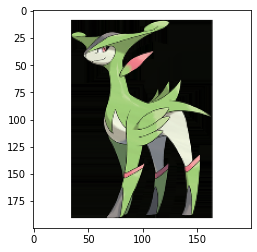

In [ ]:
val_img = Image.open(df.iloc[1049]["img"])
plt.imshow(val_img)
inputs = transforms.ToTensor()(val_img)
inputs = inputs.unsqueeze(0).to(device)

model2.eval()
outputs = model2(inputs)
pe, predicted = torch.max(outputs.data, 1)

print(predicted)
print(pe[0] * 100)
print(outputs)


tensor([[0.5000, 0.5000]], device='cuda:0', grad_fn=<SortBackward0>) tensor([[1, 0]], device='cuda:0')
Top-1 伝説でない 50.00%
Top-2 伝説 50.00%


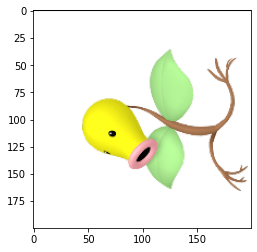

In [ ]:
val_img = Image.open(df.iloc[20800]["img"])
plt.imshow(val_img)
inputs = transforms.ToTensor()(val_img)
inputs = inputs.unsqueeze(0).to(device)

model2.eval()
outputs = model2(inputs)
batch_probs = F.softmax(outputs, dim=1)
batch_probs, batch_indices = batch_probs.sort(dim=1, descending=True)

print(batch_probs, batch_indices)

class_names = ["伝説", "伝説でない"]
for probs, indices in zip(batch_probs, batch_indices):
    for k in range(2):
        print(f"Top-{k + 1} {class_names[indices[k]]} {probs[k]:.2%}")
